In [1]:
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import torch
from matplotlib import pyplot as plt
from torch.utils.data import random_split

from utils.dl.model import MCDUNet
from utils.dl.niab import (IMG_TRANSFORMS_NO_JITTER, MASK_TRANSFORMS,
                           SegmentationDataset)

%matplotlib ipympl


UNET_MODEL_PATH = "../models_2/20240607085726/best_model.pth"
DEEPLAB_MODEL_PATH = "../models_2/20240606081206/best_model.pth"
MCD_UNET_MODEL_PATH = "../models_2/20240606080937/best_model.pth"

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
niab_dataset = SegmentationDataset(
    img_dir="../datasets/niab/EXP01/Top_Images/Annotated_Test_Dataset/imgs",
    mask_dir="../datasets/niab/EXP01/Top_Images/Annotated_Test_Dataset/masks",
    img_transforms=IMG_TRANSFORMS_NO_JITTER,
    mask_transforms=MASK_TRANSFORMS,
    common_transforms=None,
)

# Split the dataset into training and validation sets
total_size = len(niab_dataset)

# Split the dataset into training, validation and test sets
total_size = len(niab_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)  # 10% for validation
test_size = total_size - train_size - val_size  # ~10% for testing

_, _, test_dataset = random_split(niab_dataset, [train_size, val_size, test_size])

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Running model using {device} device")

unet = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
    activation="sigmoid",  # model output activation function (e.g. softmax for multiclass classification)
).to(device)

deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.
    classes=1,  # model output channels (number of classes in your dataset
    activation="sigmoid",  # model output activation function (e.g. softmax for multiclass classification)
).to(device)

# # Create an instance of the model and move it to the device (GPU or CPU)
mcd_unet = MCDUNet(
    n_channels=3,
    n_classes=1,
    bilinear=True,
    ddims=[32, 64, 128, 256, 512],
    UQ=True,
    activation=True,
).to(device)

unet.load_state_dict(torch.load(UNET_MODEL_PATH))
unet.eval()

deeplab.load_state_dict(torch.load(DEEPLAB_MODEL_PATH))
deeplab.eval()

mcd_unet.load_state_dict(torch.load(MCD_UNET_MODEL_PATH))
mcd_unet.eval()

Running model using cuda device


MCDUNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), st

In [16]:
# take random image from dataset
rand_idx = np.random.randint(0, len(test_dataset))

img, mask = niab_dataset[rand_idx]

# U-Net
unet_pred = unet(img.unsqueeze(0).to(device))
unet_binary_pred = (unet_pred > 0.3).float()
unet_binary_pred = unet_binary_pred.squeeze(0).squeeze(0).detach().cpu().numpy()

# DeepLab
deeplab_pred = deeplab(img.unsqueeze(0).to(device))
deeplab_binary_pred = (deeplab_pred > 0.3).float()
deeplab_binary_pred = deeplab_binary_pred.squeeze(0).squeeze(0).detach().cpu().numpy()

# MCD U-Net
mcd_unet_pred = mcd_unet(img.unsqueeze(0).to(device))
mcd_unet_binary_pred = (mcd_unet_pred > 0.3).float()
mcd_unet_binary_pred = mcd_unet_binary_pred.squeeze(0).squeeze(0).detach().cpu().numpy()

(-0.5, 255.5, 255.5, -0.5)

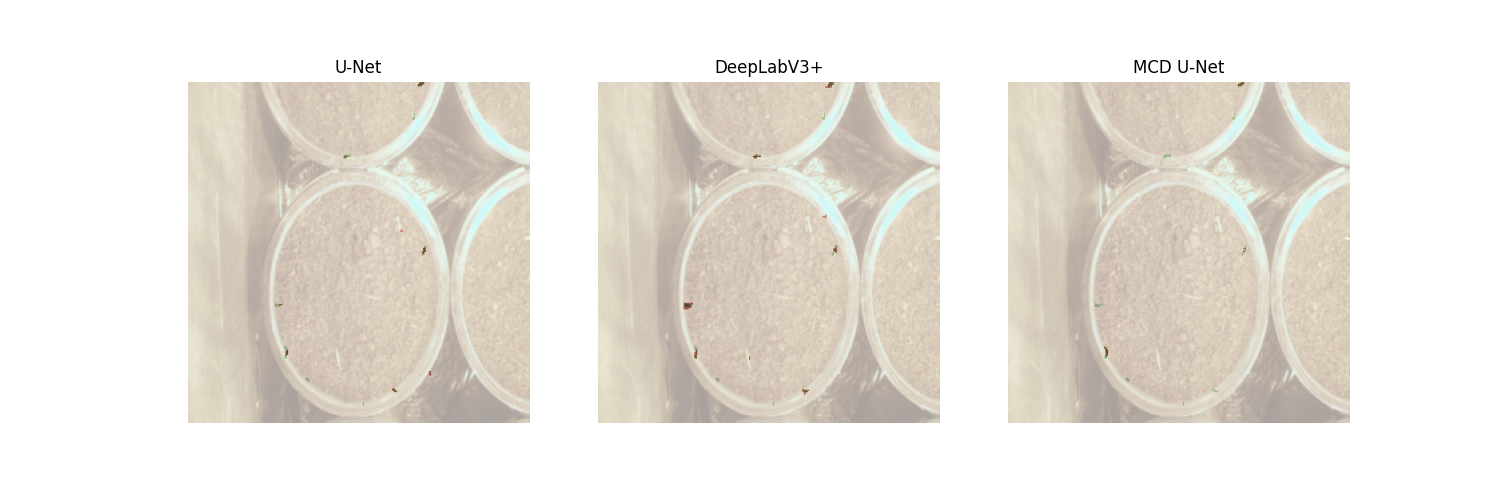

In [17]:
# visualise prediction - three images side by side with annotation overlayed with opacity

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img.permute(1, 2, 0))
ax[0].imshow(mask.squeeze(0).squeeze(0), alpha=0.4, cmap="Greens")
ax[0].imshow(unet_binary_pred, alpha=0.4, cmap="Reds")
ax[0].set_title("U-Net")
# remove axis
ax[0].axis("off")

ax[1].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask.squeeze(0).squeeze(0), alpha=0.4, cmap="Greens")
ax[1].imshow(deeplab_binary_pred, alpha=0.4, cmap="Reds")
ax[1].set_title("DeepLabV3+")
# remove axis
ax[1].axis("off")

ax[2].imshow(img.permute(1, 2, 0))
ax[2].imshow(mask.squeeze(0).squeeze(0), alpha=0.4, cmap="Greens")
ax[2].imshow(mcd_unet_binary_pred, alpha=0.4, cmap="Reds")
ax[2].set_title("MCD U-Net")
# remove axis
ax[2].axis("off")